# Executive Summary

In [ ]:
# Methdology / logic: 
# 1) identify drivers of marketing and asssess weight of importance
# 2) optmize: click thru rate = func(drivers, target audience)
# 3) design experiment to evaluate the effectiveness of new strategy

In [85]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## 1.Data Operations

In [2]:
os.chdir('/Users/yupinghe/Documents/Data-Science-Take-Home-Challenges/Data Science Take Home Challenges/Marketing Email Campaign/email')

In [3]:
# Import data
d0 = pd.read_csv('email_opened_table.csv')
d0['opened']=1
d1 = pd.read_csv('email_table.csv')
d2 = pd.read_csv('link_clicked_table.csv')
d2['clicked'] = 1

In [4]:
# Merge into 1 dataset
d = pd.merge(d1, d0, left_on='email_id', right_on='email_id', how='left')
d = pd.merge(d, d2, left_on='email_id', right_on='email_id', how='left')
d.loc[:,['clicked','opened']] = d.loc[:,['clicked','opened']].fillna(0)

In [5]:
# 50 emails were not opened but with links clicked
d['flagged'] = 0
d.loc[(d['clicked']==1) & (d['opened']==0),'flagged'] = 1

## 2. Data Quality Report

In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 10 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
opened                 100000 non-null float64
clicked                100000 non-null float64
flagged                100000 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 8.4+ MB


In [29]:
# d['email_text'].unique()
print(d['opened'].value_counts())
print(d['opened'].value_counts() / d['opened'].count())


0.0    89655
1.0    10345
Name: opened, dtype: int64
0.0    0.89655
1.0    0.10345
Name: opened, dtype: float64


    email_text  open rate
0   long_email   0.091177
1  short_email   0.115860


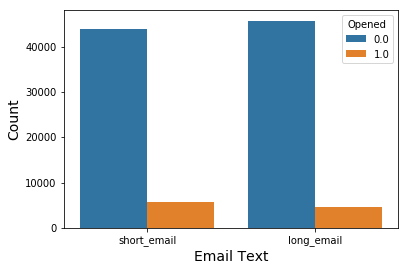

In [38]:
# email_text
print(d\
    .groupby('email_text')['opened']\
    .mean()\
    .reset_index().rename(columns={'opened':'open rate'}))

sns.countplot(x="email_text",
              hue='opened'
              ,dodge=True
              ,data=d)

plt.xlabel('Email Text', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Opened', loc='upper right')
plt.show()

  email_version  open rate
0       generic   0.079348
1  personalized   0.127754


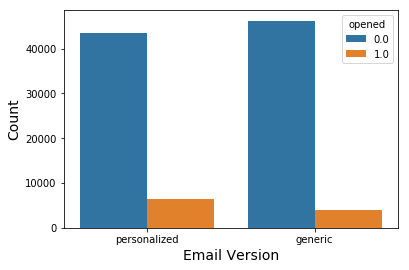

In [39]:
# email_version

print(d\
    .groupby('email_version')['opened']\
    .mean()\
    .reset_index().rename(columns={'opened':'open rate'}))

sns.countplot(x="email_version"
              ,hue='opened'
              , data=d)


plt.xlabel('Email Version', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

     weekday  open rate
5    Tuesday   0.120484
6  Wednesday   0.120278
4   Thursday   0.118442
1     Monday   0.116062
2   Saturday   0.087652
3     Sunday   0.087649
0     Friday   0.074134


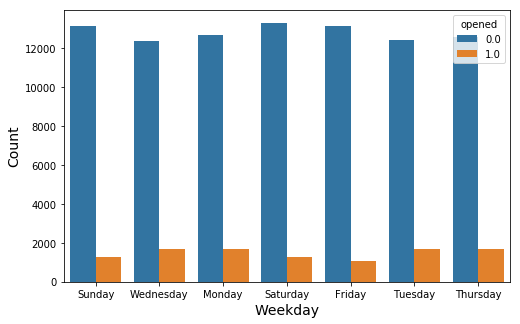

In [56]:
# weekday
print(d\
    .groupby('weekday')['opened']\
    .mean()\
    .reset_index().rename(columns={'opened':'open rate'})\
    .sort_values('open rate', ascending=False))

sns.countplot(x="weekday"
              ,hue='opened'
              , data=d)

plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

  user_country  open rate
2           UK   0.120167
3           US   0.119020
1           FR   0.040620
0           ES   0.039129


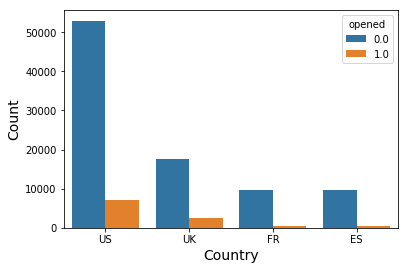

In [57]:
# user_country

print(d\
    .groupby('user_country')['opened']\
    .mean()\
    .reset_index().rename(columns={'opened':'open rate'})\
    .sort_values('open rate', ascending=False))


sns.countplot(x="user_country"
              ,hue='opened'
              , data=d)

plt.xlabel('Country', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

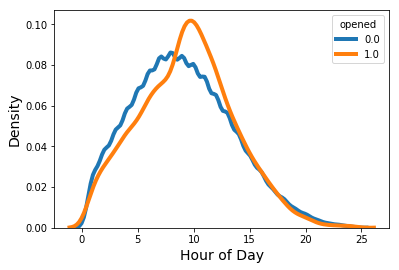

In [64]:
# hour
for i in d['opened'].unique():  
    sns.distplot(d.loc[d['opened']==i,'hour'], 
                 hist=False, 
                 kde=True,
                 #bins=int(180/5), 
                 #color = 'darkblue', # for histogram bars
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4},
                label=i)

plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='opened')
plt.show()

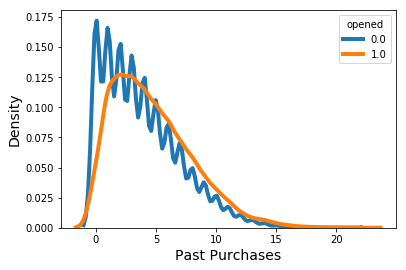

In [63]:
# user_past_purchases

for i in d['opened'].unique():
    sns.distplot(d.loc[d['opened']==i, 'user_past_purchases'], 
                 hist=False, 
                 kde=True,
                 #bins=int(180/5), 
                 #color = 'darkblue', # for histogram bars
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4}
                ,label=i)

plt.xlabel('Past Purchases', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='opened')
plt.show()

### 2.1 Missing Value Imputation

In [65]:
# 50 emails were not opened but with links clicked
d['flagged'] = 0
d.loc[(d['clicked']==1) & (d['opened']==0),'flagged'] = 1

In [67]:
d_cleaned = d.loc[d['flagged']==0,:]

d_cleaned.isna().sum().reset_index().transpose()

,0,1,2,3,4,5,6,7,8,9
index,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked,flagged
0,0,0,0,0,0,0,0,0,0,0


## 3. Feature Engineering

In [68]:
d_cleaned['email_id'].nunique()

99950

In [69]:
# Data Partition

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_index = d_cleaned.set_index('email_id').sample(frac=0.7, replace=False, random_state=4).index
test_index = d_cleaned.set_index('email_id').drop(train_index).index

### 3.1 Target Encoding

In [71]:
# Target encoding for categorical variables

# from training set only
d_cleaned2 = d_cleaned.copy()

for column in ['email_text', 'email_version', 'weekday', 'user_country']:
    # get mean by category
    temp = d_cleaned.loc[train_index,:].groupby(column)['opened'].agg({column+'_encoded':'mean'}).reset_index()
    # attach encoded value
    d_cleaned2 = pd.merge(d_cleaned2, temp, left_on=column, right_on=column, how='left')
    
    del temp


/Users/yupinghe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [72]:
final_variables = ['hour',
                   'user_past_purchases',
                   'email_text_encoded',
                   'email_version_encoded',
                   'weekday_encoded',
                   'user_country_encoded']

print(d_cleaned2.shape)
d_cleaned2.head()

(99950, 14)


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked,flagged,email_text_encoded,email_version_encoded,weekday_encoded,user_country_encoded
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0,0,0.115795,0.127451,0.092381,0.119728
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0,0,0.095733,0.127451,0.092381,0.118819
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0,0,0.095733,0.127451,0.125000,0.119728
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0,0,0.115795,0.083944,0.118547,0.118819
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0,0,0.095733,0.083944,0.118547,0.119728


## 4. Model Development

### 4.1 Data Pre-processing

In [73]:
# Data partition

X_train = d_cleaned2.set_index('email_id').loc[train_index,final_variables]
X_test = d_cleaned2.set_index('email_id').loc[test_index,final_variables]

y_train = d_cleaned2.set_index('email_id').loc[train_index,['opened']]
y_test = d_cleaned2.set_index('email_id').loc[test_index,['opened']]

In [74]:
# Scaling
pipe = Pipeline([
    #('selector', DataFrameSelector(numeric.columns.tolist())),
    ('scaler', StandardScaler()),
])


In [75]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.fit_transform(X_test)

### 4.2 Baseline Model: Logistic Regression

In [87]:

#Function attributes
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic regression,

#threshold_plot - if True returns threshold plot for model
    
def classifier(algorithm
               ,training_x,testing_x,training_y,testing_y
               ,cf) :
    
    #model
    algorithm.fit(training_x,training_y)
    probabilities = algorithm.predict_proba(testing_x)
    
    #coefficients
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    coef_sumry = pd.DataFrame(final_variables)\
            .merge(coefficients, left_index= True, right_index= True, how='inner')
    coef_sumry.columns = ["Feature","Importance"]
    coef_sumry.sort_values(by = "Importance",ascending = False)\
        .plot('Feature', 'Importance', kind='bar')
    
    plt.show()

    #model performance 
    roc_auc = roc_auc_score(testing_y,probabilities[:,1]) 
    fpr, tpr, thresholds = roc_curve(testing_y,probabilities[:,1])
    precision, recall, thresholds2 = precision_recall_curve(testing_y, probabilities[:,1])
    
    #fig, ax = plt.subplots(1, 2, sharey=False, sharex=False)

    plt.step(fpr, tpr, label='ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    plt.step(recall[:-1], precision[:-1], label='PRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    
    print (algorithm)
    print ("ROC Area under curve : ",roc_auc,"\n")



/Users/yupinghe/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


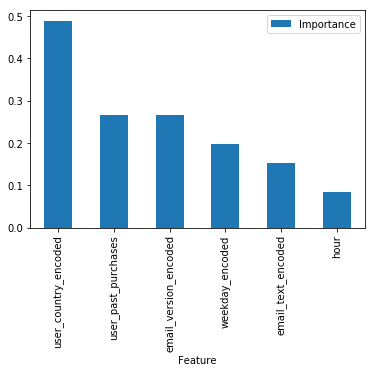

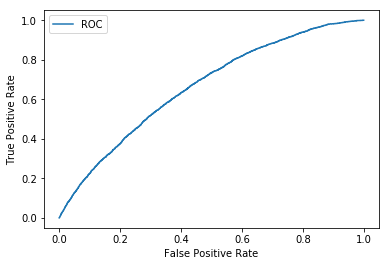

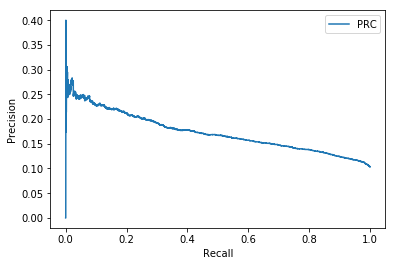

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ROC Area under curve :  0.6637459483703039 



In [88]:
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


classifier(logit,X_train,X_test,y_train,y_test,"coefficients")

### 4.3 Random Forest

#### 4.31 Hyperparameter Tuning

In [89]:
rf = RandomForestClassifier(bootstrap=True
                            ,oob_score=True
                            ,random_state=4 # seed
                            ,n_jobs=-1 # using all processors
                            ,criterion='gini')


params = {'max_features': ['auto'] # sqrt(n_features)
          ,"min_samples_leaf" : [5, 10]
          ,"min_samples_split" : [10, 20]
          ,"n_estimators": [100, 200]
         }

gs = GridSearchCV(estimator=rf
                  ,param_grid=params
                  ,scoring='roc_auc'
                  ,cv=3
                 )


In [91]:
grid_result = gs.fit(X_train, np.ravel(y_train))

print('Best parameters: ',grid_result.best_params_)
print(grid_result.best_estimator_)
print('Best AUC: ', grid_result.best_score_)

#print(grid_result.cvresults)

Best parameters:  {'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)
Best AUC:  0.6465453408200651


/Users/yupinghe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


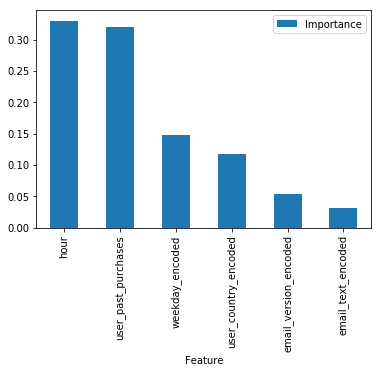

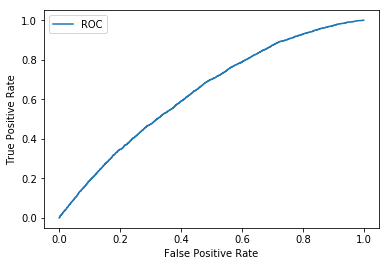

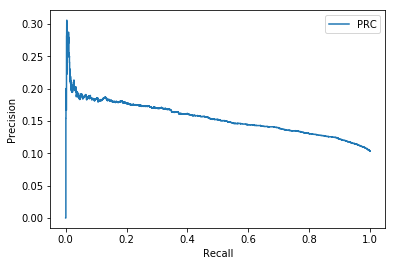

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)
ROC Area under curve :  0.638182069682059 



In [92]:
classifier(grid_result.best_estimator_,X_train,X_test,y_train,y_test,"features")

#### 4.32 Model Evaluation

In [199]:
# Fit the finalized model on entire training set

# rf = grid_result.best_estimator_

rf_final = RandomForestClassifier(criterion='gini', 
                             n_estimators=200,
                             min_samples_split=10,
                             min_samples_leaf=10,
                             max_features='auto',
                             oob_score=True,
                             random_state=4,
                             n_jobs=-1,
                             bootstrap=True)


rf_final.fit(X_train, np.ravel(y_train))
#print("%.4f" % rf_final.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=4, verbose=0, warm_start=False)

In [204]:
y_pred = rf_final.predict_proba(X_test)[:,1]
print('AUC: ', roc_auc_score(y_test, y_pred))

AUC:  0.638182069682059


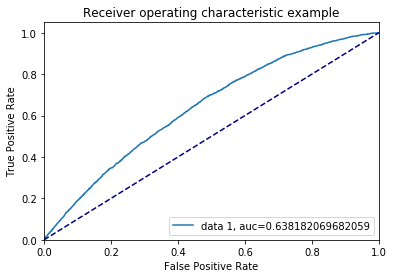

In [207]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [216]:
# feature importance
pd.concat((pd.DataFrame(d_cleaned2.loc[:, final_variables].columns, columns = ['Variable']), 
          pd.DataFrame(rf_final.feature_importances_, columns = ['Importance'])), 
          axis = 1)\
    .sort_values(by='Importance', ascending = False)

,Variable,Importance
0,hour,0.330150
1,user_past_purchases,0.320560
4,weekday_encoded,0.147293
5,user_country_encoded,0.117049
3,email_version_encoded,0.053418
2,email_text_encoded,0.031530


# Results

/Users/yupinghe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


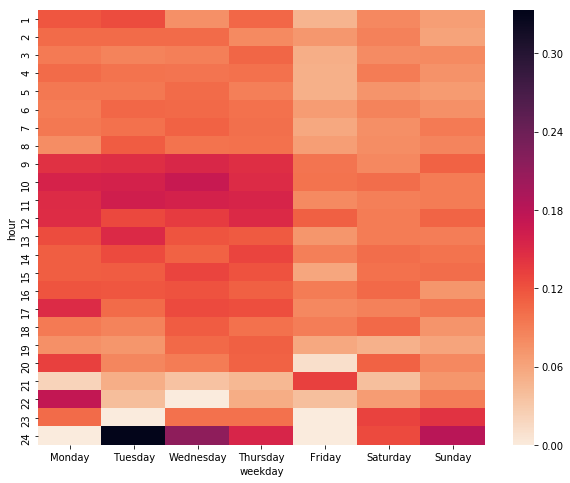

In [132]:
# Visualizing Important Features

# weekday, hour vs open rate
d_cleaned['weekday'] = d_cleaned['weekday'].astype('category')\
    .cat.reorder_categories(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)

d_temp = d_cleaned\
    .pivot_table(values='opened',index='hour',columns='weekday',aggfunc=np.mean)


plt.figure(figsize = [10,8])
sns.heatmap(d_temp, cmap=sns.cm.rocket_r)
plt.show()


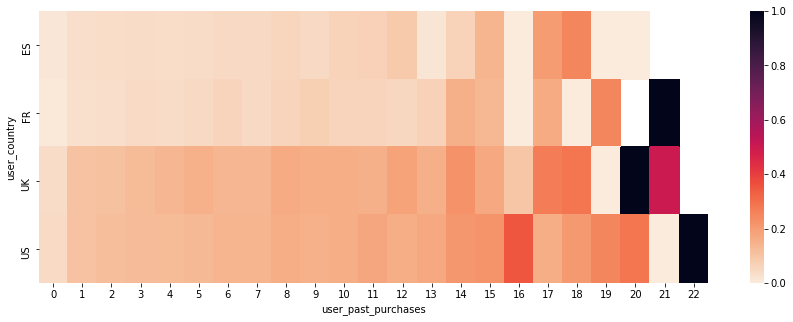

In [129]:
# country, past purchase vs open rate

d_temp = d_cleaned\
    .pivot_table(values='opened',index='user_country',columns='user_past_purchases',aggfunc=np.mean)

plt.figure(figsize = [15,5])
sns.heatmap(d_temp, cmap=sns.cm.rocket_r)

plt.show()

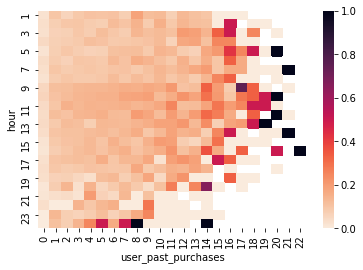

In [152]:

# plt.plot(d_cleaned['hour'], d_cleaned['user_past_purchases'],'o')

d_temp = d_cleaned\
    .pivot_table(values='opened',index='hour',columns='user_past_purchases',aggfunc=np.mean)

# plt.figure(figsize = [15,5])
sns.heatmap(d_temp, cmap=sns.cm.rocket_r)

plt.show()

In [141]:
d_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99950 entries, 0 to 99999
Data columns (total 10 columns):
email_id               99950 non-null int64
email_text             99950 non-null object
email_version          99950 non-null object
hour                   99950 non-null int64
weekday                99950 non-null category
user_country           99950 non-null object
user_past_purchases    99950 non-null int64
opened                 99950 non-null float64
clicked                99950 non-null float64
flagged                99950 non-null int64
dtypes: category(1), float64(2), int64(4), object(3)
memory usage: 10.2+ MB
